# Анализ рейсов авиакомпании

In [16]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# 1. Аналитика

In [17]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image

import math
from scipy import stats as st

import requests
import warnings
warnings.filterwarnings('ignore')

##### Импортируем файлы и изучим данные в них

In [18]:
query_1 = pd.read_csv('/datasets/query_1.csv')
query_3 = pd.read_csv('/datasets/query_3.csv')
query_last = pd.read_csv('/datasets/query_last.csv')

In [19]:
query_1

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


In [20]:
query_3

,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613
...,...,...
96,Чита,1.580645
97,Элиста,4.870968
98,Южно-Сахалинск,4.290323
99,Якутск,2.741935


In [21]:
query_last

,week_number,ticket_amount,festival_week,festival_name
0,30,43568,30.0,Park Live
1,31,51034,31.0,Пикник Афиши
2,32,51675,NaN,NaN
3,33,51378,NaN,NaN
4,34,51492,NaN,NaN
5,35,51360,NaN,NaN
6,36,51386,36.0,Видфест
7,37,51670,NaN,NaN
8,38,51518,NaN,NaN
9,39,51623,NaN,NaN


Имеем три датасета с данными о количестве рейсов, прибывающих в город сентябре 2018 года, моделей самолетов и о наличии фестиваля в городе. Представленная информация относится к 101 городу и трех проведенных фестивалях. 

##### Проверим типы данных на корректность

In [22]:
query_1.info()
print()
query_3.info()
print()
query_last.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
week_number      10 non-null int64
ticket_amount    10 non-null int64
festival_week    3 non-null float64
festival_name    3 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 448.0+ bytes


Данные имееют корректный тип, пропуски обнаружены только в датасете *query_last*, они связаны с тем, что не на каждой неделе проводились фестивали - за исследуемый период их было 3.

##### Выберем топ-10 городов по количеству рейсов

In [23]:
query_3.sort_values(by='average_flights', ascending=False).head(10)

,city,average_flights
43,Москва,129.774194
70,Санкт-Петербург,31.161290
54,Новосибирск,17.322581
33,Красноярск,11.580645
20,Екатеринбург,11.322581
67,Ростов-на-Дону,10.193548
63,Пермь,10.129032
10,Брянск,10.000000
74,Сочи,9.612903
84,Ульяновск,9.580645


Ожидаемо, города-транспортные хабы страны - Москва (с 130 рейсами в среднем) и Санкт-Петербург (с 32 рейсами) занимают лидирующие значения. Третье место у Новосибирска, так же достаточно крупного транспортного и почтового города - совершено в среднем 17 посадок в день за сентябрь месяц 2018 года. Количество прибывающих рейсов в аэропорты других городов вошедших в топ-10 колеблется от 9 до 12 в день.

##### Построим графики: 
- модели самолётов и количество рейсов

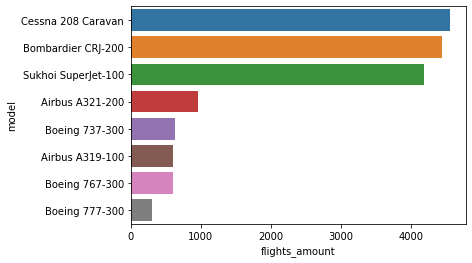

In [24]:
sns.barplot(x='flights_amount',
            y='model',
            data=query_1.sort_values(by='flights_amount', ascending=False))

Наблюдаем, что большее количество рейсов совержают самолеты малой авиации и пассаржиские самолеты с малой дальностью полета.

- города и количество рейсов

In [25]:
def getLonLatYandex(row):
    
    params = {
        'geocode': row['city'],
        'apikey': '80d8613d-1742-48c5-bb40-966660840784',
        'format': 'json'
    }
    
    r = requests.get('https://geocode-maps.yandex.ru/1.x', params=params)
    
    data = r.json()['response']['GeoObjectCollection']['featureMember']
    coord = [float(x) for x in data[0]['GeoObject']['Point']['pos'].split(' ')]
    
    assert len(coord) == 2
    
    row['lon'] = coord[0]
    row['lat'] = coord[1]
    
    return row

In [26]:
query_3 = query_3.apply(getLonLatYandex, axis=1)

In [27]:
query_3

,city,average_flights,lon,lat
0,Абакан,3.870968,91.442387,53.721152
1,Анадырь,1.000000,177.518904,64.735814
2,Анапа,2.161290,37.316170,44.894965
3,Архангельск,5.354839,40.515753,64.539911
4,Астрахань,2.451613,48.030169,46.347614
...,...,...,...,...
96,Чита,1.580645,113.501049,52.033635
97,Элиста,4.870968,44.269759,46.307743
98,Южно-Сахалинск,4.290323,142.737987,46.959148
99,Якутск,2.741935,129.732178,62.027216


In [28]:
import json
import string
import plotly
from plotly.graph_objs import Scattermapbox, Layout

query_3 = query_3[['city', 'lat', 'lon', 'average_flights']].dropna()

fig = go.Figure(go.Scattermapbox(lat=query_3['lat'], 
                                 lon=query_3['lon'], 
                                 text=query_3['city'],
                                 marker=dict(colorbar=dict(title="Среднее количество рейсов"),
                                             color=query_3['average_flights'],
                                             size=query_3['average_flights'])))
map_center = go.layout.mapbox.Center(lat=(query_3['lat'].max()+query_3['lat'].min())/2, 
                                     lon=(query_3['lon'].max()+query_3['lon'].min())/2)
fig.update_layout(mapbox_style="open-street-map",
                  mapbox=dict(center=map_center, zoom=2))
fig.show()

Рассматривая bubble-карту так же наблюдаем превалируещее место Москвы в среднем количестве совершенных рейсов в сентябре 2018 года. Что еще стоит отметить, дак это то, что большинство авиаперевозок сосредоточено в европейской части страны, что говорит о слабой транспортной загруженности востока страны, недостаточности инфраструктуры.

- топ-10 городов и количество рейсов

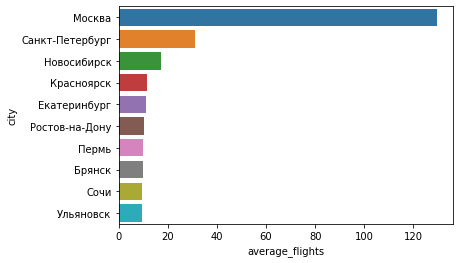

In [29]:
sns.barplot(x='average_flights',
            y='city',
            data=query_3.sort_values(by='average_flights', ascending=False).head(10))

# 2. Проверка гипотезы

Для того чтобы понять различается ли спрос на билеты во время фестивалей от среднего спроса на билеты в обычное время сформулируем гипотизу по критерию сравнения средних двух генеральных совокупностей так как мы имеем две совокупности. у которых нужно сравнить среднее значение (в нашем случае - спрос).

Нулевая гипотеза будет звучать так: Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время. 

Тогда альтернативная будет звучать следующим образом: Средний спрос на билеты во время фестивалей отличается от среднего спроса на билеты в обычное время.

Для того чтобы понять различается ли спрос на билеты во время фестивалей от среднего спроса на билеты в обычное время сформулируем гипотизу по критерию сравнения средних двух генеральных совокупностей так как мы имеем две совокупности, у которых нужно сравнить среднее значение (t-критерий Стьюдента). Уровень значимости α = 0,05, такую вероятность ошибки мы будем считать допустимой.

In [30]:
sample_1 = query_last.loc[query_last['festival_week'].isna(), 'ticket_amount']
sample_2 = query_last.loc[~query_last['festival_week'].isna(), 'ticket_amount']

alpha = .05

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Средний спрос на билеты во время фестивалей отличается от среднего спроса на билеты в обычное время")
else:
    print("Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время")

p-значение: 0.09688869045922928
Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время


In [32]:
print('Дисперсии:', np.var(sample_1), '/////', np.var(sample_2))

results = st.ttest_ind(
    sample_1, 
    sample_2,
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Средний спрос на билеты во время фестивалей отличается от среднего спроса на билеты в обычное время")
else:
    print("Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время")

Дисперсии: 14694.408163265309 ///// 12998464.888888888
p-значение: 0.377432493172683
Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время


Мы не отвергаем нулевую гипотезу "Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время", соответственно делаем вывод, что нет статистической разницы между средний спросом на авиабилеты в обычное время и в дни проведения фестивалей.

# Общий вывод

Анализ данных российской авиакомпании F9, выполняющей внутренние пассажирские авиа-перевозки дал понять, что предпочтения пользователей, покупающих билеты на разные направления не зависят от наличия в этом городе крупнейших культурных фестивалей.

Лидерами рейтинга по числу авиаперевозок являются Москва, Санкт-Петербург и Новосибирск, которые являются траспортными хабами страны - зачастую внутренние рейсы совершаются в эти города или через них (в качестве транзита). 